In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras import layers, models
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [3]:
path = r"C:\Users\sarve\Desktop\dl\datasets\creditcard\creditcard.csv"

df = pd.read_csv(path)
print("Dataset loaded successfully!")
print(df.head())

Dataset loaded successfully!
   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

   

In [4]:
X = df.drop(['Time', 'Class'], axis=1)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

x_train, x_test = train_test_split(X_scaled, test_size=0.2, random_state=42)
print(f"Training samples: {x_train.shape[0]}, Testing samples: {x_test.shape[0]}")

Training samples: 227845, Testing samples: 56962


In [5]:
encoder = models.Sequential([
    layers.Input(shape=(x_train.shape[1],)),   # 28 features
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(16, activation='relu'),       # Latent (compressed) space
])


In [6]:
decoder = models.Sequential([
    layers.Input(shape=(16,)),
    layers.Dense(32, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(x_train.shape[1], activation='linear')  # Linear for reconstruction
])

In [7]:
autoencoder = models.Sequential([encoder, decoder])

In [8]:
autoencoder.compile(
    optimizer='adam',
    loss='mse',            
    metrics=['mae']        
)

history = autoencoder.fit(
    x_train, x_train,
    validation_data=(x_test, x_test),
    epochs=20,
    batch_size=128,
    shuffle=True,
    verbose=1
)

Epoch 1/20
1781/1781 ━━━━━━━━━━━━━━━━━━━━ 23s 9ms/step - loss: 0.3142 - mae: 0.3588 - val_loss: 0.1598 - val_mae: 0.2642
Epoch 2/20
1781/1781 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - loss: 0.1184 - mae: 0.2176 - val_loss: 0.0920 - val_mae: 0.1899
Epoch 3/20
1781/1781 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - loss: 0.0856 - mae: 0.1795 - val_loss: 0.0781 - val_mae: 0.1685
Epoch 4/20
1781/1781 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - loss: 0.0678 - mae: 0.1569 - val_loss: 0.0602 - val_mae: 0.1496
Epoch 5/20
1781/1781 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - loss: 0.0595 - mae: 0.1450 - val_loss: 0.1025 - val_mae: 0.2128
Epoch 6/20
1781/1781 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - loss: 0.0529 - mae: 0.1346 - val_loss: 0.0510 - val_mae: 0.1352
Epoch 7/20
1781/1781 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - loss: 0.0473 - mae: 0.1249 - val_loss: 0.0419 - val_mae: 0.1163
Epoch 8/20
1781/1781 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - loss: 0.0431 - mae: 0.1175 - val_loss: 0.0383 - val_mae: 0.1078
Epoch 9/20
1781/1781 ━━━━━━━━━━━

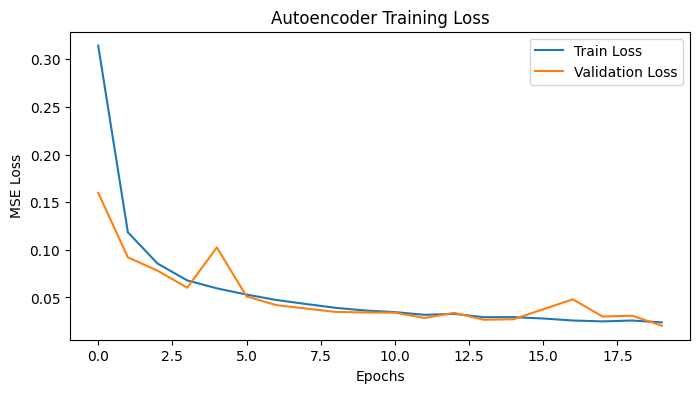

In [9]:
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Autoencoder Training Loss")
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.legend()
plt.show()

In [10]:
reconstructed = autoencoder.predict(x_test)
mse = np.mean(np.power(x_test - reconstructed, 2), axis=1)

1781/1781 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step


In [11]:
threshold = np.percentile(mse, 95)
print(f" Anomaly Detection Threshold: {threshold:.6f}")

 Anomaly Detection Threshold: 0.080146


In [12]:
anomalies = mse > threshold
num_anomalies = np.sum(anomalies)
print(f" Total Anomalies Detected: {num_anomalies}")


 Total Anomalies Detected: 2849


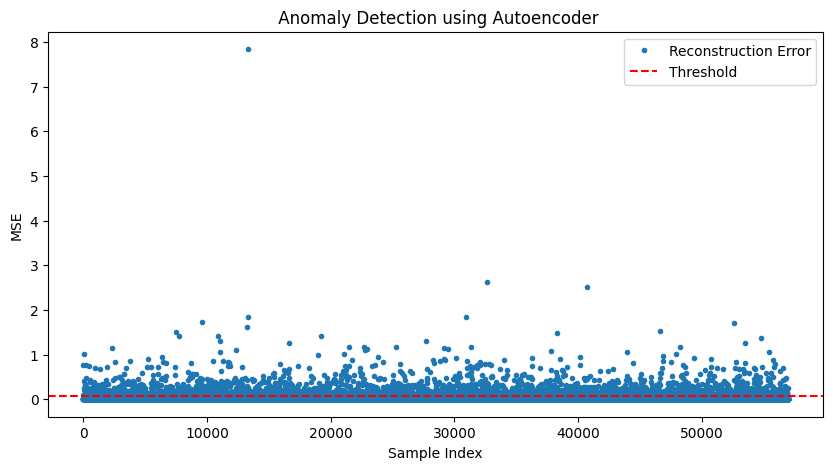

In [13]:
plt.figure(figsize=(10, 5))
plt.plot(mse, marker='o', linestyle='', markersize=3, label='Reconstruction Error')
plt.axhline(threshold, color='r', linestyle='--', label='Threshold')
plt.xlabel('Sample Index')
plt.ylabel('MSE')
plt.title(' Anomaly Detection using Autoencoder')
plt.legend()
plt.show()

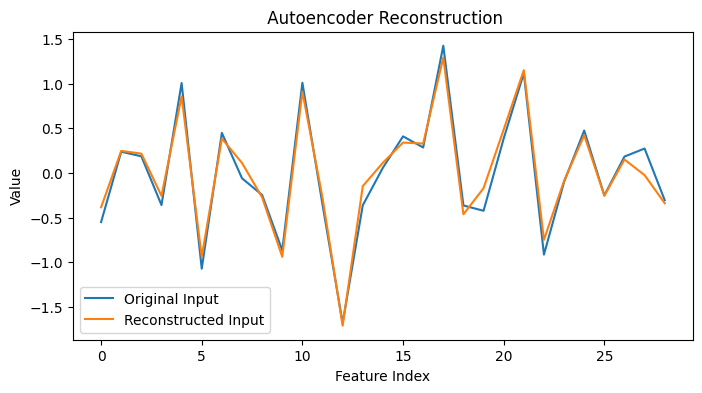

In [14]:
sample_idx = np.random.randint(0, len(x_test))
plt.figure(figsize=(8, 4))
plt.plot(x_test[sample_idx], label='Original Input')
plt.plot(reconstructed[sample_idx], label='Reconstructed Input')
plt.title(' Autoencoder Reconstruction')
plt.xlabel('Feature Index')
plt.ylabel('Value')
plt.legend()
plt.show()